In [1]:
using SpecialFunctions, Plots, ProgressMeter, LaTeXStrings, Polynomials

## Definitions

We use the definition
$$S_{h,j} = \frac{1}{(2h_\phi - h + j) (2h_\phi + h - 1 + j)}$$
It differs from the paper by a factor 
$$\frac{\Gamma(2h)}{\Gamma(h)^2} \frac{1}{\Gamma(2h_\phi - h) \Gamma(2h_\phi - 1 + h)}$$

In [2]:
N(twohϕ :: Float64, h :: Float64) = gamma(2*h) / gamma(h)^2 / gamma(twohϕ - h) / gamma(twohϕ + h - 1)

N (generic function with 1 method)

In [3]:
S(twohϕ :: Float64, h :: Float64, j :: Int) = 1.0 / ((twohϕ - h + j) * (h + twohϕ - 1 + j))

S (generic function with 1 method)

With the same normalization, we have 
$$T_{h,j} = \frac{\Gamma(h)^2 \Gamma(2h_\phi - 1 + h) \Gamma(1 - 2h_\phi + h)}
{\Gamma(2h) \Gamma(2h_\phi + h + j) \Gamma(1 - 2h_\phi + h -j)}
{}_4F_3\left( \begin{array}{c}
    h,h, 2h_\phi - 1 + h, 1 - 2h_\phi + h \\ 2h, 2h_\phi + h + j, 1 - 2h_\phi + h - j
\end{array}; 1\right)$$

This can be written as an infinite sum
$$T_{h,j} = \sum_{k = 0}^\infty T_{h,j,k}$$
with
$$T_{h,j,k} = \frac{\Gamma(h + k)^2 \Gamma(2h_\phi - 1 + h + k) \Gamma(1 - 2h_\phi + h + k)}
{k! \Gamma(2h + k) \Gamma(2h_\phi + h + j + k) \Gamma(1 - 2h_\phi + h - j + k)}$$

The $T_{h,j,k}$ obey some simple recursion relation in $j$,
$$T_{h,j+1,k} = \frac{h - 2 h_\phi - j + k}{h + 2 h_\phi + j + k} T_{h,j,k}$$
$$T_{h,0,k} = \frac{\Gamma(h + k)^2}{k! \Gamma(2h + k) (2h_\phi + h + k - 1)}$$

Then, for the term with $j = 0$ and integer-spaced values of $h$, there is the recursion relation in $h$
$$T_{h+1,0,k} = \frac{(h + k)^2 (h + 2h_\phi + k - 1)}
{(2h + k + 1) (2h + k) (2 h_\phi + h + k)}$$

Finally, for there is a recursion relation in $k$,
$$T_{h, 0, k+1} = \frac{(h+k)^2 (2 h_\phi + h + k - 1)}{(k + 1)(2h + k)(2h_\phi + h + k)} T_{h, 0, k}$$
starting at
$$T_{h, 0, 0} = \frac{\Gamma(h)^2}{\Gamma(2h) (2h_\phi + h - 1)}$$

## Matrices of $S_{h,j} - T_{h,j}$

In [4]:
S_matrix(n :: Int, twohϕ :: Float64, h0 :: Float64) = [S(twohϕ, h0 + i, j) for i = 0:n-1, j = 0:n-1]

S_matrix (generic function with 1 method)

In [5]:
function T_matrix(n :: Int, twohϕ :: Float64, h0 :: Float64; kmax :: Int = 1000000)
    Th00 = gamma(h0)^2 / gamma(2 * h0) / (twohϕ + h0 - 1)
    Th0k = [Th00]
    for k = 0:kmax-1
        Th00 *= (h0 + k)^2 * (twohϕ + h0 + k - 1) / (k + 1) / (2*h0 + k) / (twohϕ + h0 + k)
        push!(Th0k, Th00)
    end

    Thjk = [copy(Th0k)]
    k = collect(0:kmax)
    for i = 0:n-2
        h = h0 + i
        hk = h .+ k
        Th0k .*= hk.^2 .* (hk .+ (twohϕ - 1)) ./ (2*h .+ k) ./ ((2*h + 1) .+ k) ./ (hk .+ twohϕ)
        push!(Thjk, copy(Th0k))
    end
    Thjk = reduce(hcat, Thjk)'

    result = [sum(Thjk, dims=2)]
    h = h0 .+ collect(0:n-1)
    hk = h .+ k'
    for j = 0:n-2
        Thjk .*= (hk .- (j + twohϕ)) ./ ((j + twohϕ) .+ hk)
        push!(result, sum(Thjk, dims=2))
    end

    return reduce(hcat, result)
end

T_matrix (generic function with 1 method)

In [5]:
T_matrix(20, 0.5, 1.0)

20×20 Matrix{Float64}:
 2.77259     1.22741     0.105921    …  0.00518262  0.00153807  0.00414983
 0.409136    0.317765    0.16819        0.00342897  0.00306251  0.00274965
 0.154517    0.137055    0.0998248      0.00338357  0.00302506  0.00272034
 0.0801054   0.0747867   0.0619411      0.00331661  0.00297139  0.00267683
 0.0488052   0.0467005   0.0412575      0.00323129  0.00290269  0.00262092
 0.032794    0.0318083   0.0291519   …  0.00313056  0.00282111  0.00255421
 0.0235315   0.0230123   0.0215755      0.00301761  0.00272903  0.00247846
 0.0176994   0.0174013   0.0165612      0.00289564  0.00262886  0.00239554
 0.0137927   0.0136098   0.0130877      0.0027677   0.00252296  0.00230728
 0.0110491   0.0109308   0.0105901      0.00263656  0.00241353  0.00221541
 0.00904895  0.00896917  0.00873778  …  0.00250463  0.0023025   0.0021215
 0.00754628  0.00749055  0.00732808     0.00237391  0.00219156  0.00202695
 0.00638884  0.00634877  0.00623143     0.00224597  0.00208207  0.00193294
 0.

In [6]:
T_matrix(10, 1.0, 1.0)

10×10 Matrix{Float64}:
 1.64493    0.355065   0.144933   …  0.0175479   0.0137001   0.0109893
 0.355065   0.224669   0.115856      0.0169703   0.0133433   0.0107575
 0.144933   0.115856   0.0801859     0.0159171   0.0126807   0.0103212
 0.0772872  0.0677951  0.0539023     0.0145531   0.0117978   0.00972748
 0.0477108  0.0438134  0.0375283     0.0130518   0.0107912   0.00903223
 0.0322872  0.0304215  0.0272309  …  0.0115538   0.00974709  0.00828916
 0.0232664  0.02227    0.0204997     0.0101505   0.00873009  0.00754244
 0.0175479  0.0169703  0.0159171     0.00888807  0.00778074  0.00682373
 0.0137001  0.0133433  0.0126807     0.00778074  0.0069195   0.00615267
 0.0109893  0.0107575  0.0103212     0.00682373  0.00615267  0.00553921

## Asymptotics

$S$ and $T$ have identical asymptotics at large $j$, for any fixed $h$,
$$\lim_{j \to \infty} \frac{T_{h,j}}{S_{h,j}} = +1$$
but opposite asymptotics at large $h$, for any fixed $j$:
$$\lim_{h \to \infty} \frac{T_{h,j}}{S_{h,j}} = -1$$


In [7]:
TS_ratio = T_matrix(20, 0.5, 1.0) ./ S_matrix(20, 0.5, 1.0);

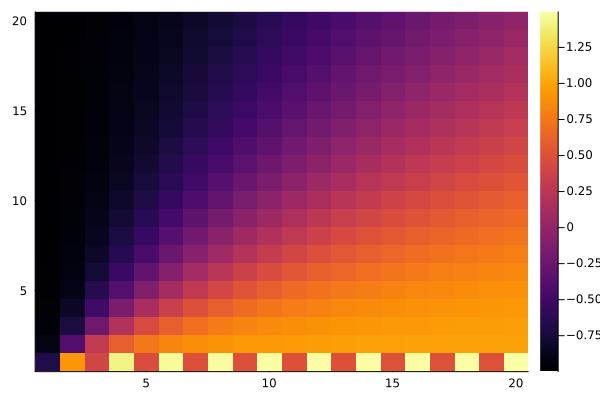

In [8]:
heatmap(TS_ratio)

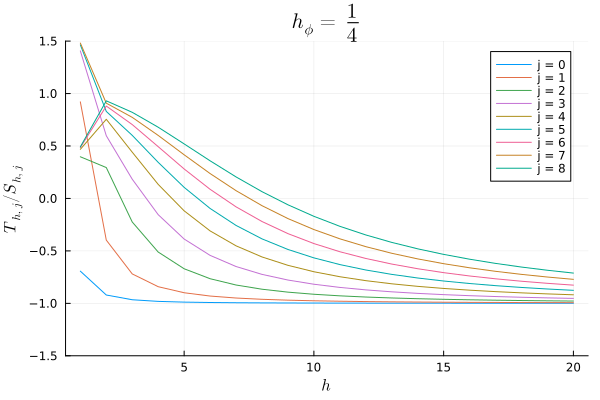

In [9]:
plot()
for j = 0:8
    plot!(TS_ratio[:,j+1], label="j = $j")
end
xlabel!(L"h")
ylims!(-1.5, 1.5)
ylabel!(L"T_{h,j} / S_{h,j}")
title!(L"h_\phi = \frac{1}{4}")

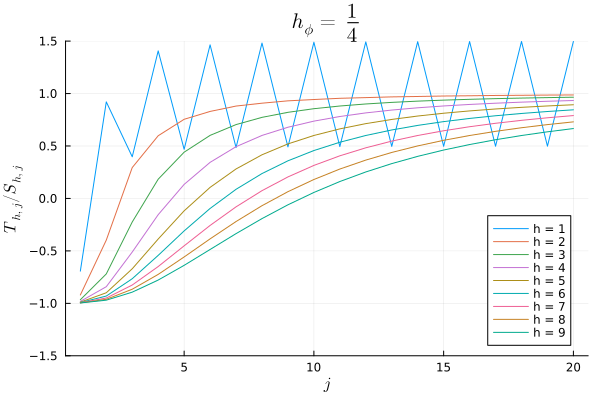

In [10]:
plot()
for h = 1:9
    plot!(TS_ratio[h,:], label="h = $h")
end
xlabel!(L"j")
ylims!(-1.5, 1.5)
ylabel!(L"T_{h,j} / S_{h,j}")
title!(L"h_\phi = \frac{1}{4}")

We define $G$ as the difference between $S$ and $T$
$$G_{h,j} = S_{h,j} - T_{h,j}$$

In [11]:
G_matrix(n :: Int, twohϕ :: Float64, h0 :: Float64; kmax :: Int = 1000000) = (
    S_matrix(n, twohϕ, h0) - T_matrix(n, twohϕ, h0, kmax=kmax))

G_matrix (generic function with 1 method)

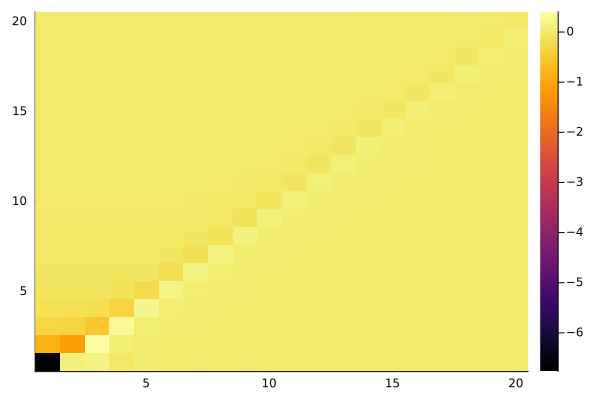

In [17]:
heatmap(G_matrix(20, 0.5, 1.0))

## Analytic inverse in the special case $h_\phi = \frac{1}{4}$

In the case $h_\phi = \frac{1}{4}$, corresponding to the energy operator of the 4-state Potts model, we define
$$S^{-1}_{j,n} = \frac{4 - 2\delta_{j0}}{\pi^2} \frac{\left( n - \frac{1}{2}\right)^2}{\left( \frac{1}{2} - n + j \right) \left( n - \frac{1}{2} + j \right)}$$
with integer $n$, such that
$$\sum_{j=0}^\infty S_{h, j} S^{-1}_{j,n} = \frac{(2n-1)^2}{(2h-1)(h+n-1)} \frac{\tan(\pi h)}{\pi (h - n)}$$

At integer $h$, we have
$$\sum_{j=0}^\infty S_{h, j} S^{-1}_{j,n}
= \delta_{hn}$$

In [13]:
Si(h :: Int, j :: Int) = (j == 0 ? 2 : 4) / pi^2 * (h - 0.5)^2 / (h - 0.5 + j) / (0.5 - h + j)

Si (generic function with 1 method)

In [14]:
Si_matrix(n :: Int) = [Si(h, j) for j = 0:n-1, h = 1:n]  

Si_matrix (generic function with 1 method)

In [15]:
Gi = inv(G_matrix(30, 0.5, 1.0));

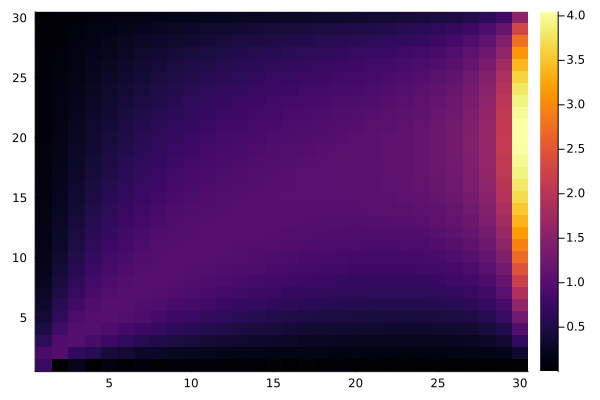

In [16]:
heatmap(Gi ./ Si_matrix(30))

In [19]:
G_matrix(30, 0.5, 1.0) * Si_matrix(30)

30×30 Matrix{Float64}:
  1.3907        1.37439       1.10466      …   1.26027      1.27836
  0.033716      1.20822       0.319384         0.423159     0.423157
  0.00872527    0.0643064     1.12723          0.252516     0.252459
  0.00340078    0.0271023     0.0606448        0.178846     0.178675
  0.00165169    0.0137101     0.0328368        0.137479     0.137136
  0.000920415   0.00782253    0.0195209    …   0.110781     0.11021
  0.000563409   0.0048596     0.0124522        0.0919735    0.0911153
  0.000369182   0.00321567    0.00838899       0.0778923    0.0766871
  0.000254715   0.00223378    0.00590171       0.0668636    0.0652501
  0.000182973   0.00161251    0.00429985       0.0579179    0.0558324
  0.000135761   0.0012008     0.00322427   …   0.0504538    0.0478298
  0.000103434   0.000917407   0.00247644       0.0440774    0.0408444
  8.0556e-5     0.000716036   0.00194092       0.0385184    0.0346003
  ⋮                                        ⋱               
  2.43625e-5   

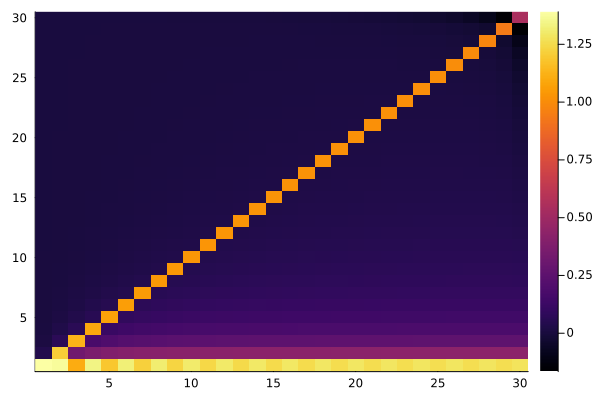

In [20]:
heatmap(G_matrix(30, 0.5, 1.0) * Si_matrix(30))

## Plots

## β functionals

In [76]:
βFcoefficients(n :: Int, twohϕ :: Float64) = inv(G_matrix(2*n - 1, twohϕ, twohϕ + 1)[1:2:2*n-1, 1:2:2*n-1])

βFcoefficients (generic function with 1 method)

In [95]:
βBcoefficients(n :: Int, twohϕ :: Float64) = inv(G_matrix(2*n, twohϕ, twohϕ + 1)[2:2:2*n, 2:2:2*n])

βBcoefficients (generic function with 1 method)

In [78]:
βFcoefficients(20, 0.5)

20×20 Matrix{Float64}:
 -0.507741     -0.18279      …   -0.0256351   -0.0311376   -0.05692
  0.421408     -2.69092          -0.29705     -0.360713    -0.65918
  0.0527408     1.99613          -0.597326    -0.725242    -1.32513
  0.0159925     0.431881         -0.896511    -1.08828     -1.9881
  0.00681868    0.174819         -1.19677     -1.45215     -2.65194
  0.00350732    0.0886182    …   -1.4999      -1.81846     -3.31876
  0.00203202    0.0510663        -1.80875     -2.18966     -3.99166
  0.00127761    0.0320319        -2.12772     -2.56947     -4.67528
  0.000852221   0.0213418        -2.4634      -2.96339     -5.37633
  0.000594108   0.0148687        -2.82564     -3.37937     -6.10431
  0.000428255   0.0107141    …   -3.22946     -3.82909     -6.87265
  0.000316623   0.00791952       -3.69866     -4.33002     -7.7005
  0.000238511   0.00596493       -4.27346     -4.90958     -8.61598
  0.000181987   0.00455089       -5.02823     -5.61356     -9.66208
  0.000139824   0.00349631 

In [79]:
βFcoefficients(20, 1.0)

20×20 Matrix{Float64}:
 -1.03964      -0.455696     -0.292603    …   -0.0901098   -0.164895
  0.815485     -3.12885      -1.53606         -0.450114    -0.823492
  0.128469      2.4065       -4.80707         -0.809932    -1.48157
  0.0431196     0.554383      4.02968         -1.17007     -2.13994
  0.0194379     0.234535      1.06479         -1.53143     -2.79976
  0.0103519     0.122564      0.503575    …   -1.89557     -3.46304
  0.00614071    0.0721776     0.286347        -2.26504     -4.133
  0.00392698    0.0460064     0.179762        -2.64369     -4.81443
  0.00265299    0.0310298     0.120334        -3.03712     -5.51421
  0.00186777    0.021826      0.0842959       -3.45345     -6.24204
  0.0013569     0.0158478     0.0610618   …   -3.90451     -7.01153
  0.00100954    0.011787      0.0453494       -4.40801     -7.8421
  0.000764425   0.00892326    0.0342993       -4.99171     -8.76222
  0.000585775   0.00683689    0.0262634       -5.702       -9.8154
  0.000451686   0.00527136 

In [80]:
βFcoefficients(20, 0.4)

20×20 Matrix{Float64}:
 -0.404398     -0.132508     -0.078833    …   -0.0217479   -0.039748
  0.340185     -2.59938      -1.27464         -0.341669    -0.624234
  0.0397939     1.91245      -4.3158          -0.708064    -1.29344
  0.0117653     0.40726       3.53809         -1.07176     -1.95748
  0.00495162    0.163139      0.905473        -1.43618     -2.62218
  0.00252712    0.082127      0.416632    …   -1.80294     -3.28974
  0.00145654    0.0470984     0.231811        -2.17451     -3.96326
  0.000912425   0.0294398     0.143065        -2.55457     -4.64734
  0.000606967   0.0195632     0.0944867       -2.9486      -5.34867
  0.000422249   0.0136017     0.0654798       -3.36453     -6.0767
  0.000303871   0.00978526    0.0470192   …   -3.81399     -6.84483
  0.000224364   0.00722354    0.0346706       -4.31442     -7.67216
  0.00016883    0.0054349     0.0260671       -4.89316     -8.58672
  0.000128704   0.00414283    0.0198606       -5.59588     -9.63142
  9.88114e-5    0.003180

In [96]:
βBcoefficients(20, 0.4)

20×20 Matrix{Float64}:
 -1.46302      -0.666269    …   -0.117683   -0.143241   -0.262346
  1.11025      -3.4804          -0.425957   -0.518369   -0.949196
  0.193961      2.72413         -0.72036    -0.876518   -1.60478
  0.0689232     0.649507        -1.01499    -1.23471    -2.26008
  0.0321606     0.282248        -1.31121    -1.59422    -2.91695
  0.0175217     0.150425    …   -1.61094    -1.95676    -3.5776
  0.0105614     0.0898847       -1.91725    -2.32497    -4.24539
  0.00683412    0.0579304       -2.23478    -2.7028     -4.92524
  0.00465875    0.0394097       -2.57035    -3.09595    -5.62416
  0.00330311    0.0279101       -2.93412    -3.51264    -6.352
  0.00241326    0.0203775   …   -3.34147    -3.96484    -7.12253
  0.00180377    0.0152246       -3.8168     -4.47045    -7.95538
  0.00137102    0.0115689       -4.4013     -5.05751    -8.87928
  0.00105395    0.00889185      -5.1712     -5.77287    -9.93819
  0.00081488    0.006874        -6.2869     -6.70217   -11.2035
  0.

## γ functionals

In [22]:
# function compute_normalized_OPEcoeffs(twohϕ :: Float64, hmax :: Int = 50, kmax :: Int = 100000)
#     G = compute_G(twohϕ, hmax, kmax)
#     Gi = inv(G)
#     gamma0 = transpose(Gi) * [(-1)^j for j = 0:hmax-1]
#     gammaN = [(-1)^n for n = 1:hmax]

#     return gammaN ./ gamma0
# end

In [6]:
function compute_normalized_OPEcoeffs(twohϕ :: Float64, hmax :: Int = 20; kmax :: Int = 1000000, kerror :: Bool = true)
    # estimate error by computing the inverse of a matrix with 100%, 110% and 120% of the requested size
    reduced_hmax = (hmax .* (10, 11, 12)) .÷ 10
    G = compute_G(twohϕ, reduced_hmax[3], kmax=kmax, error=kerror)
    all_values = []
    for h in reduced_hmax
        Gi = inv(G[1:h, 1:h])
        push!(all_values, (transpose(Gi) * [(-1)^j for j = 0:h-1])[1:hmax] ./ [(-1)^n * gamma(twohϕ)^2 for n = 1:hmax])
    end

    max_values = maximum(reduce(hcat, [Measurements.value.(val) + Measurements.uncertainty.(val) for val in all_values]), dims=2)
    min_values = minimum(reduce(hcat, [Measurements.value.(val) - Measurements.uncertainty.(val) for val in all_values]), dims=2)
    return measurement.((max_values .+ min_values) / 2, (max_values .- min_values) / 2)
end

compute_normalized_OPEcoeffs (generic function with 2 methods)

In [7]:
normalization(twohϕ :: Float64, hmax :: Int = 50) = [
    (-1)^h * gamma(2*h) / gamma(h)^2 / gamma(twohϕ - h) / gamma(twohϕ + h - 1) for h = 1:hmax]

normalization (generic function with 2 methods)

In [8]:
compute_OPEcoeffs(twohϕ :: Float64, hmax :: Int = 50; kmax :: Int = 100000, kerror = true) = (
    compute_normalized_OPEcoeffs(twohϕ, hmax, kmax=kmax, kerror=kerror) ./ normalization(twohϕ, hmax))

compute_OPEcoeffs (generic function with 2 methods)

## Performance tests

Choosing a very large value for $k_{max}$ does not impact the computation time significantly:

In [10]:
@time compute_normalized_OPEcoeffs(0.5, 10, kmax=100)

  0.154312 seconds (739.90 k allocations: 34.362 MiB, 4.50% gc time)


10×1 Matrix{Measurement{Float64}}:
 0.07958 ± 0.00098
  0.3581 ± 0.0045
  0.4971 ± 0.0076
   0.732 ± 0.011
   0.905 ± 0.015
    1.13 ± 0.02
   1.312 ± 0.027
   1.529 ± 0.042
   1.737 ± 0.083
    1.73 ± 0.34

In [11]:
@time compute_normalized_OPEcoeffs(0.5, 10, kmax=1000)

  0.161166 seconds (739.92 k allocations: 38.159 MiB, 7.00% gc time)


10×1 Matrix{Measurement{Float64}}:
 0.07958 ± 0.0002
 0.35807 ± 0.00097
  0.4973 ± 0.002
   0.731 ± 0.0038
  0.9068 ± 0.0067
   1.127 ± 0.011
   1.316 ± 0.02
   1.523 ± 0.036
   1.745 ± 0.08
    1.72 ± 0.34

In [12]:
@time compute_normalized_OPEcoeffs(0.5, 10, kmax=10000)

  0.168728 seconds (739.92 k allocations: 76.130 MiB, 3.51% gc time)


10×1 Matrix{Measurement{Float64}}:
 0.079577 ± 2.7e-5
  0.35809 ± 0.00024
  0.49744 ± 0.00088
   0.7309 ± 0.0022
    0.907 ± 0.0047
   1.1271 ± 0.0091
    1.316 ± 0.017
    1.522 ± 0.033
    1.746 ± 0.077
     1.71 ± 0.34

In [13]:
@time compute_normalized_OPEcoeffs(0.5, 10, kmax=100000)

  0.516935 seconds (739.92 k allocations: 455.845 MiB, 39.45% gc time)


10×1 Matrix{Measurement{Float64}}:
 0.079578 ± 1.1e-5
  0.35808 ± 0.00017
  0.49745 ± 0.00075
   0.7309 ± 0.0021
    0.907 ± 0.0045
   1.1271 ± 0.0089
    1.316 ± 0.017
    1.522 ± 0.033
    1.746 ± 0.077
     1.71 ± 0.34

It is therefore recommended to use the default value of 1,000,000

In [14]:
@time compute_normalized_OPEcoeffs(0.5, 10)

  2.410281 seconds (739.92 k allocations: 4.153 GiB, 24.40% gc time)


10×1 Matrix{Measurement{Float64}}:
 0.0795785 ± 9.2e-6
   0.35808 ± 0.00016
   0.49745 ± 0.00074
    0.7309 ± 0.002
     0.907 ± 0.0045
    1.1271 ± 0.0088
     1.316 ± 0.017
     1.522 ± 0.033
     1.746 ± 0.077
      1.71 ± 0.34

On the contrary, increasing $h_{max}$ is very expensive:

In [17]:
@time compute_normalized_OPEcoeffs(0.5, 15)

  6.712580 seconds (5.00 M allocations: 9.216 GiB, 9.32% gc time)


15×1 Matrix{Measurement{Float64}}:
 0.0795771 ± 2.6e-6
  0.358105 ± 4.3e-5
   0.49733 ± 0.00019
    0.7312 ± 0.00051
    0.9063 ± 0.0011
    1.1287 ± 0.002
    1.3128 ± 0.0034
    1.5308 ± 0.0054
    1.7181 ± 0.0084
     1.935 ± 0.013
     2.121 ± 0.02
     2.344 ± 0.032
     2.515 ± 0.057
      2.79 ± 0.12
      2.59 ± 0.53

In [18]:
@time compute_normalized_OPEcoeffs(0.5, 20)

 27.051294 seconds (21.25 M allocations: 16.693 GiB, 4.35% gc time)


20×1 Matrix{Measurement{Float64}}:
 0.07957807 ± 7.6e-7
  0.3580868 ± 6.3e-6
   0.497414 ± 2.1e-5
   0.730969 ± 5.3e-5
    0.90675 ± 0.00011
     1.1278 ± 0.00019
     1.3143 ± 0.00032
    1.52846 ± 0.00049
    1.72173 ± 0.00073
     1.9299 ± 0.0011
     2.1298 ± 0.0015
     2.3309 ± 0.0022
     2.5394 ± 0.0032
     2.7298 ± 0.0046
     2.9527 ± 0.007
      3.123 ± 0.011
      3.377 ± 0.019
      3.491 ± 0.038
      3.876 ± 0.099
       3.35 ± 0.56

In [19]:
@time compute_normalized_OPEcoeffs(0.5, 25)

 98.137651 seconds (61.71 M allocations: 27.130 GiB, 1.96% gc time)


25×1 Matrix{Measurement{Float64}}:
 0.0795775 ± 1.1e-6
 0.3581001 ± 9.4e-6
  0.497351 ± 3.2e-5
  0.731141 ± 8.0e-5
   0.90639 ± 0.00016
   1.12848 ± 0.00029
   1.31319 ± 0.00047
    1.5302 ± 0.00072
    1.7192 ± 0.0011
    1.9336 ± 0.0015
    2.1247 ± 0.002
    2.3379 ± 0.0027
    2.5298 ± 0.0035
     2.743 ± 0.0046
    2.9344 ± 0.0059
    3.1488 ± 0.0076
    3.3381 ± 0.0097
     3.556 ± 0.013
      3.74 ± 0.017
     3.967 ± 0.022
     4.136 ± 0.031
     4.389 ± 0.046
     4.504 ± 0.076
       4.9 ± 0.16
      4.25 ± 0.76

This can be vastly improved by ignoring the error due to the summation over k:

In [20]:
@time compute_normalized_OPEcoeffs(0.5, 25, kerror=false)

  3.411016 seconds (1.69 M allocations: 1008.572 MiB, 13.22% gc time, 22.96% compilation time)


25×1 Matrix{Measurement{Float64}}:
 0.07957736 ± 3.2e-7
  0.3581006 ± 5.8e-6
    0.49735 ± 2.6e-5
   0.731142 ± 7.1e-5
    0.90639 ± 0.00015
    1.12848 ± 0.00028
    1.31318 ± 0.00046
     1.5302 ± 0.0007
     1.7192 ± 0.001
     1.9336 ± 0.0015
     2.1247 ± 0.002
     2.3379 ± 0.0027
     2.5298 ± 0.0035
      2.743 ± 0.0045
     2.9343 ± 0.0059
     3.1488 ± 0.0075
     3.3381 ± 0.0097
      3.556 ± 0.013
       3.74 ± 0.016
      3.967 ± 0.022
      4.136 ± 0.031
      4.389 ± 0.046
      4.504 ± 0.076
        4.9 ± 0.16
       4.25 ± 0.76

In [21]:
@time compute_normalized_OPEcoeffs(0.5, 50, kerror=false)

  8.907405 seconds (1.08 k allocations: 1.796 GiB, 6.60% gc time)


50×1 Matrix{Measurement{Float64}}:
 0.079577476 ± 3.1e-8
  0.35809854 ± 5.6e-7
   0.4973596 ± 2.5e-6
    0.731117 ± 6.9e-6
    0.906439 ± 1.5e-5
     1.12838 ± 2.7e-5
    1.313345 ± 4.4e-5
    1.529953 ± 6.7e-5
    1.719522 ± 9.8e-5
     1.93309 ± 0.00014
     2.12537 ± 0.00018
     2.33696 ± 0.00024
     2.53106 ± 0.00031
             ⋮
       7.805 ± 0.016
       8.001 ± 0.019
       8.213 ± 0.022
       8.403 ± 0.026
       8.623 ± 0.032
       8.801 ± 0.04
        9.04 ± 0.051
       9.187 ± 0.068
        9.48 ± 0.098
        9.52 ± 0.16
       10.09 ± 0.33
         8.6 ± 1.5

In [58]:
@time normalized_OPEcoeffs_Potts4 = compute_normalized_OPEcoeffs(0.5, 100, kerror=false)

 27.451416 seconds (1.97 k allocations: 3.585 GiB, 3.19% gc time)


100×1 Matrix{Measurement{Float64}}:
 0.07957747394 ± 7.4e-10
   0.358098579 ± 1.3e-8
   0.497359392 ± 6.0e-8
    0.73111749 ± 1.6e-7
    0.90643826 ± 3.5e-7
    1.12838164 ± 6.3e-7
     1.3133425 ± 1.0e-6
     1.5299572 ± 1.6e-6
     1.7195152 ± 2.3e-6
      1.933097 ± 3.2e-6
     2.1253614 ± 4.4e-6
     2.3369798 ± 5.8e-6
     2.5310358 ± 7.4e-6
               ⋮
        17.962 ± 0.019
        18.104 ± 0.022
        18.377 ± 0.027
        18.497 ± 0.033
        18.799 ± 0.041
        18.881 ± 0.053
        19.236 ± 0.071
         19.24 ± 0.1
         19.73 ± 0.15
         19.47 ± 0.27
         20.58 ± 0.6
          17.2 ± 2.9

## Actual and guessed values in the free fermion and 4-state Potts model

In [60]:
normalized_OPEcoeffs_Potts4[1:6] ./ ([1/4, 9/8, 25/16, 147/64, 729/256, 1815/512] ./ pi)

6-element Vector{Measurement{Float64}}:
 1.0000000301 ± 9.3e-9
   0.99999988 ± 3.7e-8
   1.00000039 ± 1.2e-7
   0.99999928 ± 2.2e-7
   1.00000123 ± 3.8e-7
   0.99999819 ± 5.6e-7

In [55]:
OPEcoeffs_Potts4 = compute_OPEcoeffs(0.5, 99, kerror=false)

99×1 Matrix{Measurement{Float64}}:
   0.499999997 ± 1.7e-8
   0.125000003 ± 1.7e-8
  0.0208333316 ± 9.5e-9
  0.0046875007 ± 3.9e-9
   0.001004464 ± 1.4e-9
 0.00023251497 ± 4.9e-10
   5.284426e-5 ± 1.6e-10
  1.2448905e-5 ± 4.9e-11
    2.90474e-6 ± 1.5e-11
   6.920129e-7 ± 4.4e-12
   1.638974e-7 ± 1.3e-12
    3.93485e-8 ± 3.6e-13
    9.40939e-9 ± 1.0e-13
               ⋮
           0.0 ± 0.0
           0.0 ± 0.0
           0.0 ± 0.0
           0.0 ± 0.0
           0.0 ± 0.0
           0.0 ± 0.0
           0.0 ± 0.0
           0.0 ± 0.0
           0.0 ± 0.0
           0.0 ± 0.0
           0.0 ± 0.0
           0.0 ± 0.0

In [56]:
OPEcoeffs_Potts4[2:2:10] ./ [1/8, 3/640, 5/21504, 175/14057472, 441/637272064]

5-element Vector{Measurement{Float64}}:
 1.00000003 ± 1.4e-7
 1.00000016 ± 8.4e-7
  1.0000004 ± 2.1e-6
  1.0000007 ± 3.9e-6
  1.0000012 ± 6.3e-6

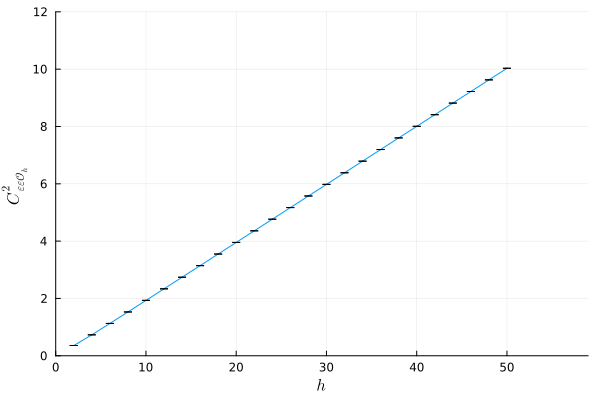

In [78]:
plot([2:2:50], normalized_OPEcoeffs_Potts4[2:2:50], label="")
xlims!(0, 59)
ylims!(0, 12)
xlabel!(L"h")
ylabel!(L"C_{\varepsilon\varepsilon\mathcal{O}_h}^2")

In [69]:
normalized_OPEcoeffs_Potts4[2:2:20]

10-element Vector{Measurement{Float64}}:
 0.358098579 ± 1.3e-8
  0.73111749 ± 1.6e-7
  1.12838164 ± 6.3e-7
   1.5299572 ± 1.6e-6
    1.933097 ± 3.2e-6
   2.3369798 ± 5.8e-6
   2.7412729 ± 9.3e-6
    3.145815 ± 1.4e-5
    3.550519 ± 2.0e-5
    3.955333 ± 2.8e-5

6-element Vector{Float64}:
 0.07957747154594767
 0.3580986219567645
 0.4973591971621729
 0.7311180198283942
 0.9064371368280602
 1.1283836785616799

In [20]:
# [compute_OPEcoeffs(0.5, 20)[1:6] / pi ;; [1/2, 1/8, 1/48, 3/640, 9/8960, 5/21504]]
# [compute_OPEcoeffs(0.5, 20)[2:2:10] / pi ;; [1/8, 3/640, 5/21504, 175/14057472, 441/637272064]]

In [22]:
# [compute_OPEcoeffs(0.999, 20)[1:5] ;; [1, 1/2, 1/6, 1/20, 1/70]]
# [compute_OPEcoeffs(0.999, 20)[2:2:10] ;; 1/2 * [1, 1/10, 1/126, 1/1716, 1/24310]]

In [57]:
compute_OPEcoeffs(0.9999, 50, kerror=false)[2:2:10] ./ [1, 1/10, 1/126, 1/1716, 1/24310]

5-element Vector{Measurement{Float64}}:
 0.4998999 ± 1.9e-6
 0.4998166 ± 1.9e-6
 0.4997716 ± 1.9e-6
 0.4997407 ± 1.9e-6
 0.4997171 ± 1.9e-6

## Other values of $h_\phi$

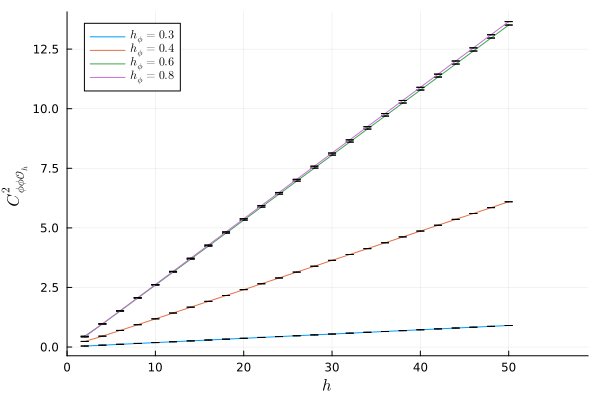

In [81]:
plot([2:2:50], compute_normalized_OPEcoeffs(0.2, 100, kerror=false)[2:2:50], label=L"h_\phi = 0.3")
plot!([2:2:50], compute_normalized_OPEcoeffs(0.4, 100, kerror=false)[2:2:50], label=L"h_\phi = 0.4")
plot!([2:2:50], compute_normalized_OPEcoeffs(0.6, 100, kerror=false)[2:2:50], label=L"h_\phi = 0.6")
plot!([2:2:50], compute_normalized_OPEcoeffs(0.8, 100, kerror=false)[2:2:50], label=L"h_\phi = 0.8")
xlims!(0, 59)
# ylims!(0, 12)
xlabel!(L"h")
ylabel!(L"C_{\phi\phi\mathcal{O}_h}^2")

## Plots for arbitrary $h_\phi$

In [26]:
# hphi = [[0.001] ; [i/20 for i=1:9] ; [0.499]]
hphi = [[0.001, 0.01] ; [i/40 for i=1:19] ; [0.499]]
# hphi = [[0.001] ; [i/40 for i=1:19] ; [0.499] ; [0.5 + i/20 for i=1:9]]

22-element Vector{Float64}:
 0.001
 0.01
 0.025
 0.05
 0.075
 0.1
 0.125
 0.15
 0.175
 0.2
 0.225
 0.25
 0.275
 0.3
 0.325
 0.35
 0.375
 0.4
 0.425
 0.45
 0.475
 0.499

In [27]:
OPEcoeffs = reduce(hcat, @showprogress [compute_OPEcoeffs(2*h, 50, kerror=false) for h ∈ hphi]);


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17

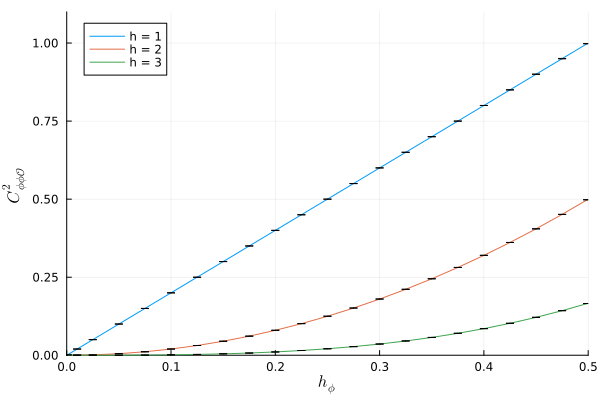

In [28]:
plot()
for h = 1:3
    plot!(hphi, OPEcoeffs[h, :], label="h = $h")
end
xlims!(0, 0.5)
ylims!(0, 1.1)
xlabel!(L"h_\phi")
ylabel!(L"C_{\phi\phi\mathcal{O}}^2")

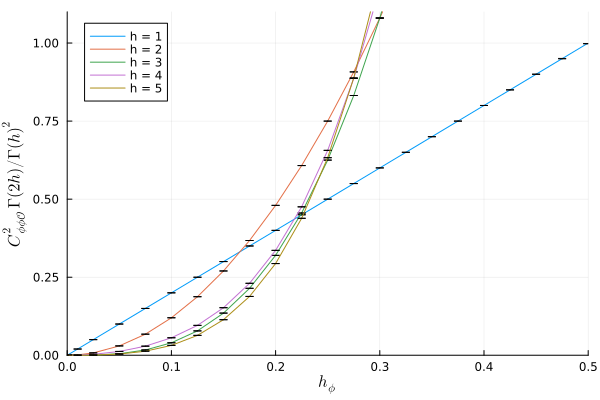

In [29]:
plot()
for h = 1:5
    plot!(hphi, OPEcoeffs[h, :] ./ (gamma(h)^2 / gamma(2*h)), label="h = $h")
end
xlims!(0, 0.5)
ylims!(0, 1.1)
xlabel!(L"h_\phi")
ylabel!(L"C_{\phi\phi\mathcal{O}}^2 \Gamma(2h) / \Gamma(h)^2")
# ylabel!(L"\frac{\Gamma(2h)}{\Gamma(h)^2} C_{\phi\phi\mathcal{O}}^2")

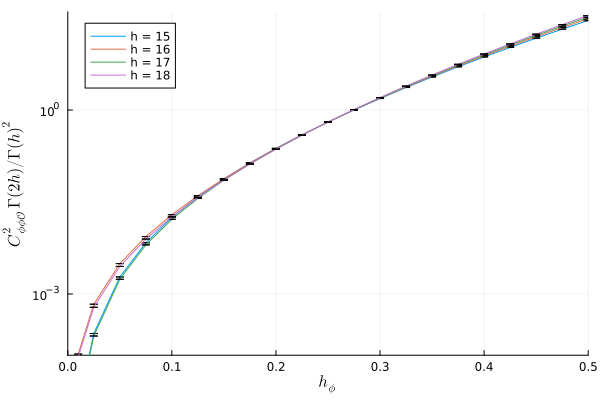

In [30]:
plot(yscale=:log10)
for h = 15:18
    plot!(hphi, OPEcoeffs[h, :] ./ (gamma(h)^2 / gamma(2*h)), label="h = $h")
end
xlims!(0, 0.5)
ylims!(1e-4, 40)
xlabel!(L"h_\phi")
ylabel!(L"C_{\phi\phi\mathcal{O}}^2 \Gamma(2h) / \Gamma(h)^2")
# ylabel!(L"\frac{\Gamma(2h)}{\Gamma(h)^2} C_{\phi\phi\mathcal{O}}^2")

### Compare with Virasoro vacuum module

At $h = 1$, we observe $C_1^2 = 2h_\phi$:

In [31]:
OPEcoeffs[1, :] ./ (2 .* hphi)

22-element Vector{Measurement{Float64}}:
 0.999999999608 ± 6.1e-11
  0.99999999657 ± 6.3e-10
    0.999999993 ± 1.6e-9
   0.9999999893 ± 2.9e-9
   0.9999999874 ± 3.8e-9
   0.9999999867 ± 4.2e-9
   0.9999999874 ± 4.1e-9
   0.9999999888 ± 4.6e-9
    0.999999989 ± 1.2e-8
    0.999999996 ± 4.3e-8
     1.00000001 ± 1.3e-7
     1.00000005 ± 3.9e-7
      1.0000002 ± 1.1e-6
      1.0000004 ± 2.9e-6
       1.000001 ± 7.7e-6
       1.000002 ± 2.0e-5
       1.000005 ± 4.8e-5
        1.00001 ± 0.00011
        1.00002 ± 0.00024
        1.00003 ± 0.00046
        1.00004 ± 0.00066
       1.000004 ± 7.2e-5

At $h = 2$ the operator is the energy-momentum tensor and its OPE coefficient squared must be
$$C_{\phi\phi T}^2 = \frac{2 h_\phi^2}{c}$$
This lets us compute $c$, and we find $c = 1$.

This is consistent with the 4-state Potts model at $h_\phi = 1/4$ (4-state Potts model) and the free Dirac fermion when $h_\phi = 1/2$.

In [32]:
C2(h) = 2 * h^2

C2 (generic function with 1 method)

In [33]:
OPEcoeffs[2, :] ./ C2.(hphi)

22-element Vector{Measurement{Float64}}:
  1.00000044 ± 1.2e-7
   1.0000004 ± 1.1e-7
  1.00000035 ± 1.0e-7
 1.000000272 ± 8.6e-8
 1.000000215 ± 7.0e-8
 1.000000168 ± 5.6e-8
 1.000000124 ± 4.1e-8
 1.000000088 ± 3.7e-8
 1.000000073 ± 7.9e-8
  1.00000002 ± 2.4e-7
  0.99999994 ± 6.2e-7
   0.9999998 ± 1.6e-6
   0.9999994 ± 3.8e-6
   0.9999988 ± 8.8e-6
    0.999997 ± 2.0e-5
    0.999995 ± 4.5e-5
     0.99999 ± 9.6e-5
     0.99998 ± 0.00019
     0.99997 ± 0.00037
     0.99996 ± 0.00062
     0.99995 ± 0.00076
    0.999996 ± 7.3e-5

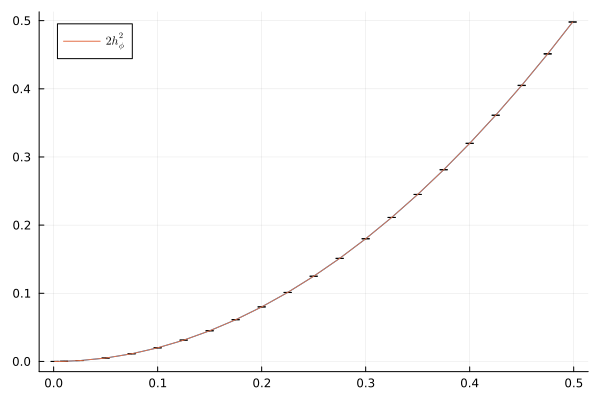

In [34]:
plot(hphi, OPEcoeffs[2, :], label="")
plot!(hphi, 2 .* hphi.^2, label=L"2 h_\phi^2")

At $h = 3$, we observe $C_3^2 = \frac{4}{3} h_\phi^3$:

In [35]:
OPEcoeffs[3, :] ./ (4 / 3 .* hphi.^3)

22-element Vector{Measurement{Float64}}:
    0.99953 ± 0.00014
   0.999957 ± 1.4e-5
  0.9999852 ± 4.8e-6
  0.9999942 ± 1.9e-6
   0.999997 ± 1.0e-6
  0.9999983 ± 5.7e-7
 0.99999903 ± 3.3e-7
 0.99999944 ± 2.4e-7
 0.99999962 ± 4.1e-7
  0.9999999 ± 1.0e-6
  1.0000002 ± 2.3e-6
  1.0000007 ± 5.0e-6
   1.000002 ± 1.1e-5
   1.000003 ± 2.2e-5
   1.000006 ± 4.4e-5
    1.00001 ± 8.7e-5
    1.00002 ± 0.00016
    1.00003 ± 0.0003
    1.00004 ± 0.00051
    1.00005 ± 0.00076
    1.00005 ± 0.00085
   1.000004 ± 7.3e-5

At $h = 4$ the computation using the Virasoro algebra yields
$$C_4^2 = \frac{2 h_\phi^2 (1 + 5h_\phi)^2}{5c (5c + 22)}$$
or with $c = 1$,
$$C_4^2 = \frac{2 h_\phi^2 (1 + 5h_\phi)^2}{135}$$

In [36]:
C4(h) = 2 / 135 * h^2 * (1 + 5*h)^2

C4 (generic function with 1 method)

In [37]:
OPEcoeffs[4, :] ./ C4.(hphi)

22-element Vector{Measurement{Float64}}:
  2.2277346 ± 7.3e-6
  2.0449167 ± 6.2e-6
  1.8000139 ± 4.7e-6
  1.5120086 ± 2.9e-6
  1.3239724 ± 1.8e-6
  1.2000034 ± 1.1e-6
  1.1183452 ± 6.7e-7
 1.06530727 ± 4.9e-7
 1.03200078 ± 8.5e-7
  1.0125002 ± 2.1e-6
  1.0027677 ± 4.5e-6
  0.9999987 ± 9.3e-6
   1.002213 ± 1.9e-5
   1.007995 ± 3.7e-5
   1.016317 ± 7.1e-5
    1.02643 ± 0.00013
    1.03778 ± 0.00024
    1.04996 ± 0.00041
    1.06266 ± 0.00066
    1.07567 ± 0.00093
    1.08883 ± 0.00098
   1.101512 ± 8.1e-5

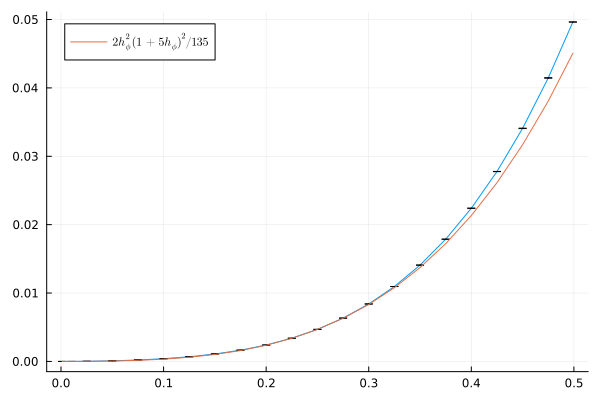

In [38]:
plot(hphi, OPEcoeffs[4, :], label="")#, yscale=:log10, ylims=(1e-8,1))
plot!(hphi, C4.(hphi), label=L"2 h_\phi^2 (1 + 5 h_\phi)^2 / 135")

In [39]:
C6(h) = h^2 * (17 + 140*h + 1736*h^2 - 840*h^3 + 2772*h^4) / 42525

C6 (generic function with 1 method)

In [40]:
OPEcoeffs[6, :] ./ C6.(hphi)

22-element Vector{Measurement{Float64}}:
  2.625417 ± 5.2e-5
  2.431509 ± 4.3e-5
  2.131735 ± 3.2e-5
  1.733047 ± 1.8e-5
 1.4589859 ± 9.9e-6
 1.2789193 ± 5.5e-6
 1.1627336 ± 2.8e-6
 1.0888969 ± 1.8e-6
 1.0433027 ± 2.9e-6
 1.0168772 ± 6.3e-6
  1.003739 ± 1.2e-5
  0.999997 ± 2.3e-5
  1.003011 ± 4.3e-5
  1.010941 ± 7.7e-5
   1.02247 ± 0.00013
   1.03663 ± 0.00023
   1.05268 ± 0.00038
   1.07007 ± 0.0006
   1.08836 ± 0.00088
    1.1072 ± 0.0011
    1.1263 ± 0.0011
  1.144756 ± 8.4e-5

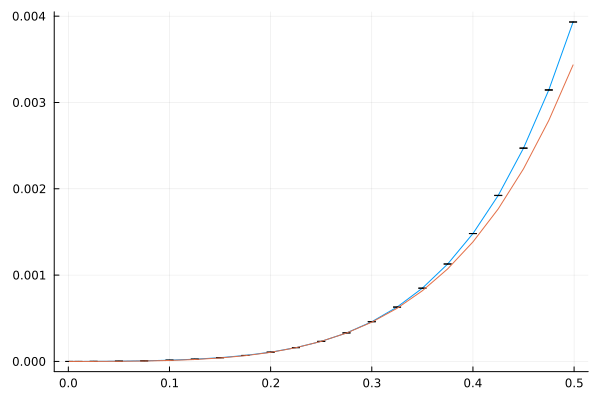

In [41]:
plot(hphi, OPEcoeffs[6, :], label="")
plot!(hphi, C6.(hphi), label="")

In [42]:
C8(h) = h^2 * (3375 + 21210*h + 490231*h^2 + 198000*h^3 + 510048*h^4 + 640640*h^5 + 782496*h^6) / 227026800

C8 (generic function with 1 method)

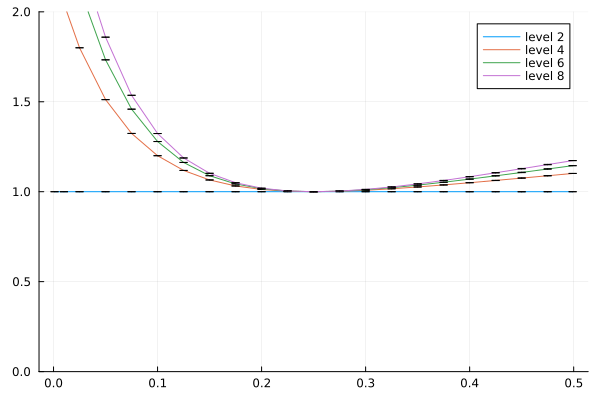

In [43]:
plot(hphi, OPEcoeffs[2, :] ./ C2.(hphi), label="level 2", ylims=(0,2))
plot!(hphi, OPEcoeffs[4, :] ./ C4.(hphi), label="level 4")
plot!(hphi, OPEcoeffs[6, :] ./ C6.(hphi), label="level 6")
plot!(hphi, OPEcoeffs[8, :] ./ C8.(hphi), label="level 8")

### Experiments

In practice, the error on T is so small that it can be neglected. This allows to use much larger matrices:

In [43]:
G = compute_G(0.75, 100, 100000)

100×100 Matrix{Measurement{Float64}}:
    -7.3679±2.5e-6    0.129829±2.5e-6  …    -1.58e-5±2.2e-6
  -0.836384±2.5e-6    -1.71928±2.5e-6         9.6e-6±2.2e-6
  -0.311077±2.5e-6   -0.338982±2.5e-6         9.7e-6±2.2e-6
  -0.160694±2.5e-6   -0.164685±2.5e-6         9.8e-6±2.2e-6
 -0.0977732±2.5e-6  -0.0987138±2.5e-6         9.9e-6±2.2e-6
 -0.0656542±2.5e-6  -0.0659485±2.5e-6  …     1.01e-5±2.2e-6
 -0.0470922±2.5e-6  -0.0472034±2.5e-6        1.04e-5±2.2e-6
 -0.0354116±2.5e-6  -0.0354597±2.5e-6        1.07e-5±2.2e-6
 -0.0275899±2.5e-6  -0.0276129±2.5e-6         1.1e-5±2.2e-6
  -0.022098±2.5e-6    -0.02211±2.5e-6        1.14e-5±2.2e-6
 -0.0180952±2.5e-6  -0.0181018±2.5e-6  …     1.18e-5±2.2e-6
 -0.0150882±2.5e-6  -0.0150921±2.5e-6        1.22e-5±2.2e-6
 -0.0127723±2.5e-6  -0.0127746±2.5e-6        1.27e-5±2.2e-6
           ⋮                           ⋱  
 -0.0002457±2.3e-6  -0.0002457±2.3e-6      0.0004481±2.0e-6
 -0.0002401±2.3e-6  -0.0002401±2.3e-6      0.0004965±2.0e-6
 -0.0002346±2.3e-6 

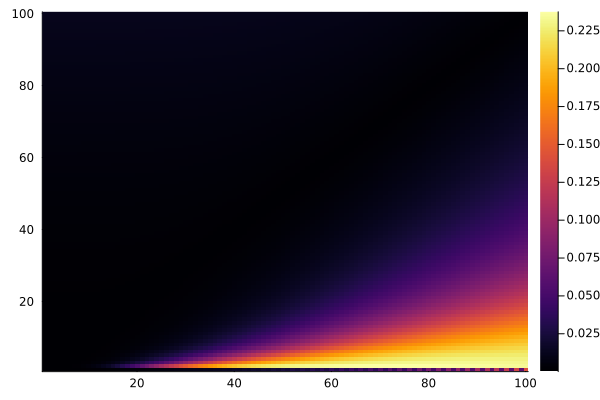

In [45]:
G_relative_uncertainty = Measurements.uncertainty.(G) ./ abs.(Measurements.value.(G))
heatmap(G_relative_uncertainty)

In [46]:
findmax(G_relative_uncertainty)

(0.2375745241597708, CartesianIndex(2, 75))

In [47]:
Gi = inv(Measurements.value.(G))

100×100 Matrix{Float64}:
 -0.13429      -0.00738905  -0.0124021    …   -0.000316965   -8.25974e-5
  0.0685375    -0.547036    -0.103697         -0.000756085   -0.00119311
  0.0224141     0.221541    -0.953454         -0.00166373    -0.00228739
  0.011116      0.0892833    0.368875         -0.00269625    -0.0036315
  0.00661307    0.0508808    0.159121         -0.0038868     -0.0051981
  0.00437516    0.033198     0.0968185    …   -0.00524073    -0.00698274
  0.00310484    0.0234274    0.0665784        -0.00675959    -0.00898415
  0.00231591    0.0174291    0.048961         -0.00844394    -0.0112019
  0.00179296    0.0134754    0.0376334        -0.0102941     -0.0136358
  0.00142875    0.0107301    0.0298699        -0.0123102     -0.0162857
  0.00116505    0.00874579   0.0243001    …   -0.0144924     -0.0191518
  0.000968053   0.00726495   0.0201619        -0.0168408     -0.0222341
  0.000817036   0.00613053   0.0170008        -0.0193555     -0.0255326
  ⋮                               

In [48]:
Gi

100×100 Matrix{Float64}:
 -0.13429      -0.00738905  -0.0124021    …   -0.000316965   -8.25974e-5
  0.0685375    -0.547036    -0.103697         -0.000756085   -0.00119311
  0.0224141     0.221541    -0.953454         -0.00166373    -0.00228739
  0.011116      0.0892833    0.368875         -0.00269625    -0.0036315
  0.00661307    0.0508808    0.159121         -0.0038868     -0.0051981
  0.00437516    0.033198     0.0968185    …   -0.00524073    -0.00698274
  0.00310484    0.0234274    0.0665784        -0.00675959    -0.00898415
  0.00231591    0.0174291    0.048961         -0.00844394    -0.0112019
  0.00179296    0.0134754    0.0376334        -0.0102941     -0.0136358
  0.00142875    0.0107301    0.0298699        -0.0123102     -0.0162857
  0.00116505    0.00874579   0.0243001    …   -0.0144924     -0.0191518
  0.000968053   0.00726495   0.0201619        -0.0168408     -0.0222341
  0.000817036   0.00613053   0.0170008        -0.0193555     -0.0255326
  ⋮                               

Can we understand the asymptotic behavior of the coefficients?

In [9]:
using LinearAlgebra

In [10]:
G = compute_G(0.5, 20)
Gi = inv(G)

20×20 Matrix{Measurement{Float64}}:
 -0.145451±7.2e-6    -3.2e-6±3.4e-5   …  -0.01364±0.00034  -0.0206±0.00047
  0.117399±4.3e-5   -0.71069±0.0002        -0.145±0.002    -0.2915±0.0028
  0.016615±7.2e-5    0.49166±0.00033      -0.2681±0.0034   -0.5234±0.0047
   0.00532±0.0001    0.10662±0.00047       -0.381±0.0047   -0.7374±0.0066
   0.00233±0.00013   0.04354±0.0006       -0.4881±0.0061    -0.939±0.0084
   0.00121±0.00016   0.02221±0.00072  …   -0.5915±0.0073    -1.132±0.01
   0.00071±0.00018   0.01284±0.00085      -0.6927±0.0086    -1.318±0.012
   0.00045±0.00021   0.00806±0.00096       -0.793±0.0097    -1.501±0.014
    0.0003±0.00023    0.0054±0.0011        -0.894±0.011     -1.683±0.015
   0.00021±0.00025    0.0037±0.0012        -0.999±0.012     -1.866±0.017
   0.00015±0.00027    0.0027±0.0013   …     -1.11±0.013     -2.056±0.018
   0.00011±0.00029     0.002±0.0014        -1.232±0.014     -2.256±0.019
    8.1e-5±0.00031    0.0015±0.0014        -1.372±0.015     -2.474±0.02
    6.1e-5±

In [11]:
Gi * [S(0.5, 6, j) for j = 0:19]

20-element Vector{Measurement{Float64}}:
 0.004307 ± 3.9e-5
  0.04712 ± 0.00024
  0.05488 ± 0.00039
  0.05351 ± 0.00055
  0.04764 ± 0.0007
  0.04035 ± 0.00085
 -1.05769 ± 0.00099
   0.0269 ± 0.0011
   0.0215 ± 0.0013
   0.0171 ± 0.0014
   0.0135 ± 0.0015
   0.0105 ± 0.0016
   0.0081 ± 0.0017
   0.0062 ± 0.0018
   0.0046 ± 0.0019
   0.0034 ± 0.0019
   0.0024 ± 0.002
   0.0016 ± 0.0021
  0.00093 ± 0.0021
  0.00043 ± 0.0023

In [41]:
f7 = fit(collect(5:14), Gi[6:15, 7], 4)

Polynomial(-10.67 ± 0.24 + 1.53 ± 0.12*x + 0.235 ± 0.02*x^2 - 0.0449 ± 0.0015*x^3 + 0.00173 ± 4.0e-5*x^4)

In [42]:
f8 = fit(collect(5:14), Gi[6:15, 8], 4)

Polynomial(83.27 ± 0.27 - 41.51 ± 0.13*x + 7.241 ± 0.023*x^2 - 0.5296 ± 0.0017*x^3 + 0.013855 ± 4.6e-5*x^4)

In [28]:
f9 = fit(collect(5:19), Gi[6:20, 9], 4)

Polynomial(17.0 ± 0.11 - 7.979 ± 0.046*x + 1.2156 ± 0.0067*x^2 - 0.07399 ± 0.0004*x^3 + 0.0015629 ± 8.6e-6*x^4)

In [29]:
f10 = fit(collect(5:19), Gi[6:20, 10], 4)

Polynomial(30.29 ± 0.12 - 12.849 ± 0.051*x + 1.8211 ± 0.0074*x^2 - 0.10512 ± 0.00044*x^3 + 0.0021317 ± 9.5e-6*x^4)

In [30]:
f11 = fit(collect(5:19), Gi[6:20, 11], 4)

Polynomial(31.46 ± 0.13 - 12.723 ± 0.055*x + 1.7175 ± 0.008*x^2 - 0.09468 ± 0.00048*x^3 + 0.00184 ± 1.0e-5*x^4)

In [31]:
f12 = fit(collect(5:19), Gi[6:20, 12], 4)

Polynomial(20.32 ± 0.14 - 7.645 ± 0.059*x + 0.928 ± 0.0086*x^2 - 0.04494 ± 0.00052*x^3 + 0.000752 ± 1.1e-5*x^4)

In [39]:
pi^2 / 4 * (7 - 0.5)

16.038107151770205

In [40]:
pi^2 / 4 * (8 - 0.5)

18.505508252042546

In [20]:
0.019058 * 7 * 6 * 5

4.002179999999999

In [21]:
0.025 * 8 * 5

1.0

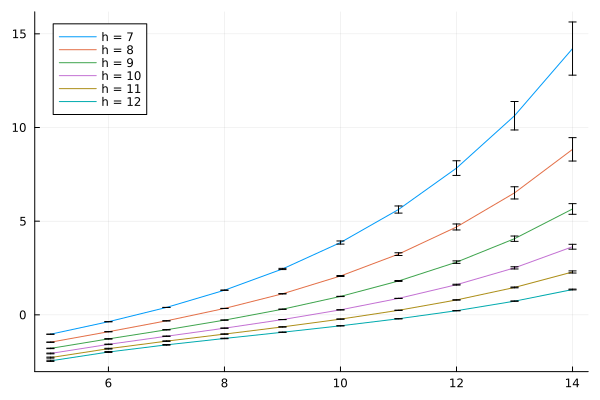

In [43]:
plot()
for h = 7:12
    plot!([5:14], Gi[6:15, h].^-1, label="h = $h")
end
plot!()

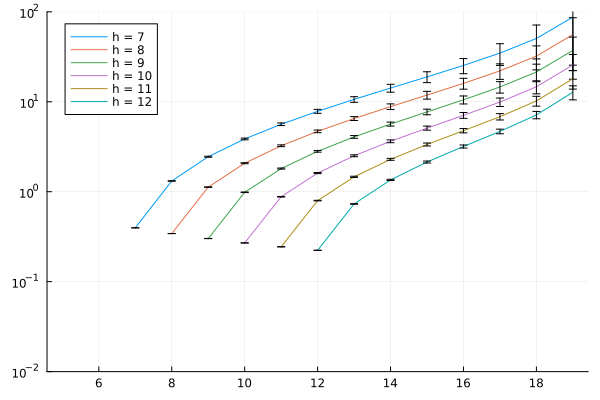

In [35]:
plot(ylims=(0.01, 100), yscale=:log10)
for h = 7:12
    plot!([5:19], Gi[6:20, h].^-1, label="h = $h")
end
plot!()

In [22]:
Gi[6:20,7].^-1

15-element Vector{Measurement{Float64}}:
  -1.0335 ± 0.0034
 -0.36495 ± 0.0005
  0.39684 ± 0.00067
   1.3159 ± 0.0082
     2.45 ± 0.031
    3.861 ± 0.084
     5.62 ± 0.19
     7.83 ± 0.39
    10.63 ± 0.76
     14.2 ± 1.4
     18.9 ± 2.6
     25.4 ± 4.9
     34.8 ± 9.4
     51.0 ± 21.0
     87.0 ± 65.0

In [13]:
Gi[7, 1:20] ⋅ [S(0.5, 4, j) for j = 0:19]

0.0327 ± 0.001